In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import io
import requests
import scipy.stats
from scipy import integrate
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Rail probe - simple data rendering
The aim of the script is to plot raw signals from individual probes: rail, Langmuir and ball-pen probe.

<center>
<img src="expsetup.svg" width=48%/>
<img src="icon-fig.png" width=48%/>
</center>

In [2]:
def get_data(shot, ch="lp"):
    """
    Stáhne data z http://golem.fjfi.cvut.cz/shots/0/, 
    bere parametr shot: číslo výboje,
    ch: kanál: lp - Langmuir, bp - Ball-pen, uloop, btor, irog
    a vrací panda tabulku index, t: čas, U: měřený signál
    """
    url = "http://golem.fjfi.cvut.cz/shots/"+str(shot)+"/Diagnostics/"+ch+".csv"
    s = requests.get(url).content
    data = pd.read_csv(io.StringIO(s.decode('utf-8')), sep=',', header=0, names=["t","U"])
    return data

In [3]:
def get_data_uloop(shot):
    calibration_uloop = 5.23*0.1966
    data_uloop = get_data(shot,ch="BasicDiagnostics/U_Loop")
    data_uloop["U"] *= calibration_uloop
    return data_uloop
    
def get_data_btor(shot):
    calibration_btor = 69.3
    data = get_data(shot,ch="BasicDiagnostics/U_BtCoil")
    zerotime = int(0.03*len(data))
    data_for_int = data["U"] - np.mean(data["U"][0:zerotime])
    data_int = integrate.cumtrapz(data_for_int, data["t"], initial=0)
    data_calibrated = calibration_btor*data_int
    data_btor = pd.DataFrame({'t': data["t"], 'U': data_calibrated})
    return data_btor

def get_data_irog(shot):
    calibration_irog = 1.42*3320000/0.8765
    resistance_ch = 0.0097/0.915
    data_irog = get_data(shot,ch="BasicDiagnostics/U_RogCoil")
    zerotime = int(0.05*len(data_irog))
    data_for_int_irog = data_irog["U"] - np.mean(data_irog["U"][0:zerotime])
    data_int_irog = integrate.cumtrapz(data_for_int_irog, data_irog["t"], initial=0)
    data_irog_calibrated = data_int_irog * calibration_irog
    data_uloop = get_data_uloop(shot)
    data_irog_calibrated = -1*data_irog_calibrated - data_uloop["U"]/resistance_ch
    data_irog = pd.DataFrame({'t': data_irog["t"], 'U': data_irog_calibrated})
    return data_irog

<IPython.core.display.Javascript object>


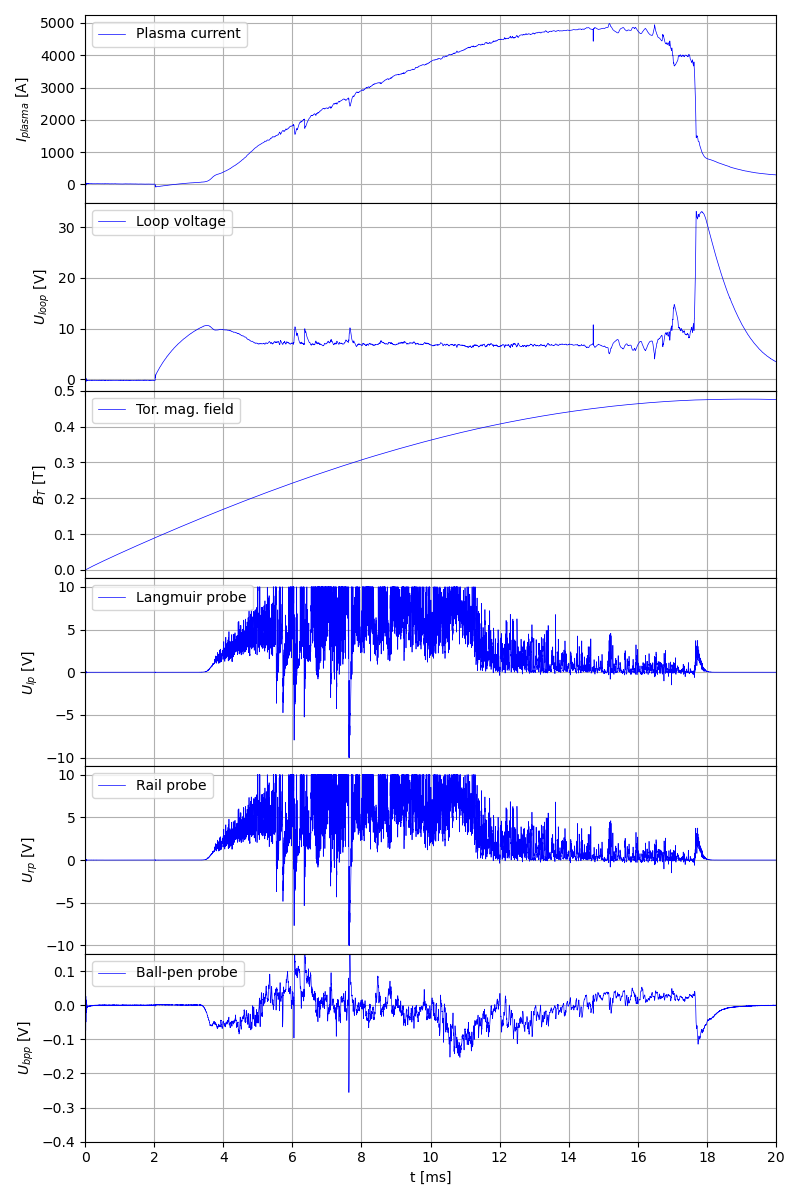

In [4]:
shot_no = 0
shotNo = shot_no
plot_start, plot_end = 0, 0.02*1e3

fig, ax = plt.subplots(6, figsize=(8, 12), sharex=True, tight_layout=True, gridspec_kw = {'wspace':0, 'hspace':0})

#irog
ax[0].plot(get_data_irog(shotNo)["t"]*1e3, get_data_irog(shotNo)["U"], "b-",label="Plasma current", linewidth=0.5)
ax[0].set(ylabel="$I_{plasma}$ [A]", xlim=[plot_start,plot_end])

#uloop
ax[1].plot(get_data_uloop(shotNo)["t"]*1e3, get_data_uloop(shotNo)["U"], "b-",label="Loop voltage", linewidth=0.5)
ax[1].set(ylabel="$U_{loop}$ [V]", xlim=[plot_start,plot_end])

#btor
ax[2].plot(get_data_btor(shotNo)["t"]*1e3, get_data_btor(shotNo)["U"], "b-",label="Tor. mag. field", linewidth=0.5)
ax[2].set(ylabel="$B_{T}$ [T]", xlim=[plot_start,plot_end])

#lp
data_lp = get_data(shotNo, ch="RailProbe/I_LP")
ax[3].plot(data_lp["t"]*1e3, data_lp["U"], "b-",label="Langmuir probe", linewidth=0.5)
ax[3].set(ylabel="$U_{lp}$ [V]", xlim=[plot_start,plot_end])#, ylim=[-0.005,0.075])

#rp
data_rp = get_data(shotNo, ch="RailProbe/I_RP")
ax[4].plot(data_rp["t"]*1e3, data_rp["U"], "b-", label="Rail probe", linewidth=0.5)
ax[4].set(ylabel="$U_{rp}$ [V]", xlim=[plot_start,plot_end])#, ylim=[-0.05,0.75])

#bpp
data_bp = get_data(shotNo, ch="RailProbe/U_fl_BPP")
ax[5].plot(data_bp["t"]*1e3, data_bp["U"], "b-",label="Ball-pen probe", linewidth=0.5)
ax[5].set(xlabel="t [ms]", ylabel="$U_{bpp}$ [V]", xlim=[plot_start,plot_end], ylim=[-0.4,0.15])

for a in ax:
    a.legend(loc=2)
    a.grid()
    a.xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.savefig('icon-fig.png')
plt.show()